# Image captioning and Visual Question Answering

This notebook implements methods for automatically generating a caption describing and image, as well as for automatically answering questions about an image.

## 1. Prepare libraries and helper functions

In [186]:
from utils.prepare_apikey_and_cache_loc import prepare_to_load_model 
prepare_to_load_model(username='cehrett')

Okay, using /scratch/cehrett/hf_cache for huggingface cache. Models will be stored there.
huggingface API key loaded.


In [187]:
# Import needed libraries
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPImage
import torch
import time
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering, AutoTokenizer, AutoModel
from transformers import VisionEncoderDecoderModel, ViTImageProcessor

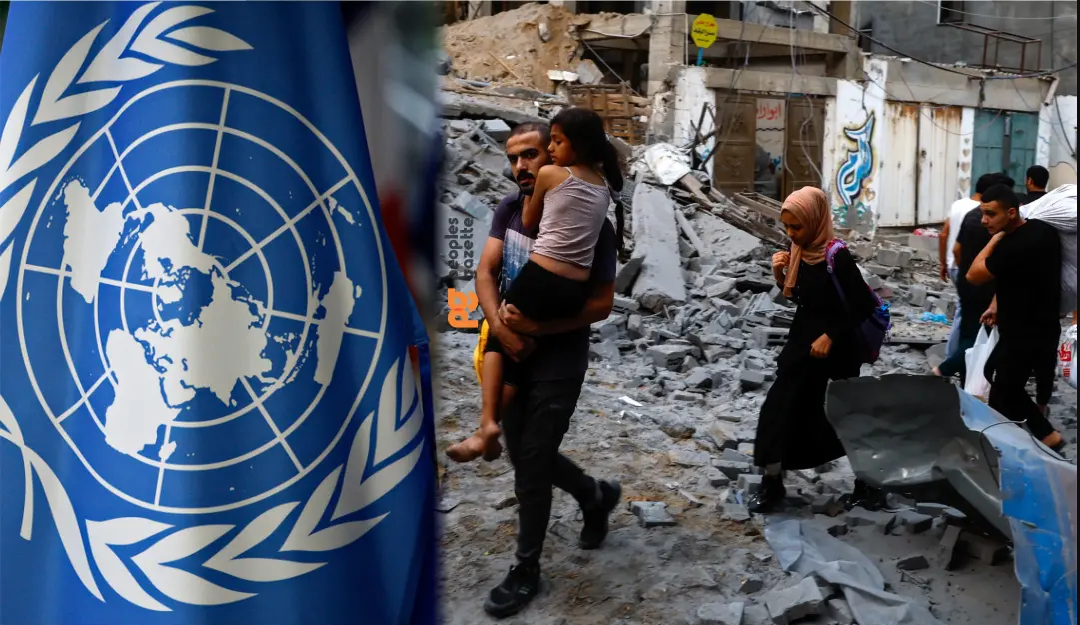

In [188]:
# Display the image used for testing
display(IPImage(filename='test.png'))

In [189]:
# Define helper function that will be used for image captioning and VQA

def describe_image(model, tokenizer, processor, question, image_loc, device='cuda:0', include_question=True):
    """
    Generates a description for the given image using the provided model and tokenizer.

    Args:
    - model (torch.nn.Module): The pretrained model for image description.
    - tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    - processor (object): The processor for the image to convert it to pixel values.
    - question (str): The prompt or question for the model.
    - image_loc (str): The input image file location.
    - device (str, optional): Device to move tensors to. Default is 'cuda:0'. (model should already be there.)

    Returns:
    - str: Decoded description of the image.
    """
    
    # Load the image using PIL
    image = Image.open(image_loc)
    if image.mode != "RGB":
      image = image.convert(mode="RGB")

    # Convert the image to pixel values and add batch dimension
    pixel_values = torch.from_numpy(processor(image).pixel_values[0]).unsqueeze(0).to(device)

    # Prepare generation kwargs
    gen_kwargs = {}
    if include_question == True:
        # Tokenize the question and move tensors to the specified device
        encoding = tokenizer(question, return_tensors='pt')
        gen_kwargs['input_ids'] = encoding['input_ids'].to(device)
        gen_kwargs['attention_mask'] = encoding['attention_mask'].to(device)

    # Time the generation process
    start_time = time.time()

    output = model.generate(
        pixel_values=pixel_values,
        max_new_tokens=200,
        **gen_kwargs
    )

    end_time = time.time()

    # Decode the output tensor
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Print the elapsed time
    print(f"Time taken to generate output: {end_time - start_time:.2f} seconds")

    return decoded_output


## 2. Image captioning and Visual Question Answering (VQnA)

Multiple models are implemented below, for comparison purposes. You might wish to test these models on multiple images, to find which works best. Note that these models may also differ in their runtime and RAM/GPU requirements.

### 2.1 Blip-2 with FlanT5 XL

In [149]:
# Load model, tokenizer, image processor

model_name = "Salesforce/blip2-flan-t5-xl"

start_time = time.time()
processor = AutoProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForVisualQuestionAnswering.from_pretrained(model_name).to(device)
end_time = time.time()
# Print the elapsed time
print(f"Time taken to load model: {end_time - start_time:.2f} seconds")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken to load model: 27.68 seconds


#### 2.1.1 Captioning

In [164]:
# Try it out for captioning
caption_question = """
Question: Please provide a comprehensively detailed description of the image. \
Take your time and be sure to include everything of potential interest in the photo.

Answer: The image shows \
"""

describe_image(model=model, tokenizer=tokenizer, question=caption_question, processor=processor, image_loc='test.png')

Time taken to generate output: 1.13 seconds


'izraeli soldiers and palestinian civilians in the rubble of a destroyed building in the gaza strip. The building is located in the al-bureij refugee camp, which is located in the northern part of the gaza strip. The building is located in the al-bureij refugee camp, which is located in the northern part of the gaza strip.\n'

#### 2.1.2 VQnA

In [165]:
people_question = """
Question: Please provide a comprehensively detailed description of all people found in the image. \
Include a count of how many people are in the image, and a description of what the people are doing. \
Take your time and be sure to include everything of potential interest in the photo.

Answer: There are \
"""

symbols_question = """
Question: Please provide a comprehensively detailed description of all symbols, flags, icons, and/or logos found in the image. \
Take your time and be sure to include everything of potential interest in the photo.

Answer: The image shows \
"""

people_txt = describe_image(model=model, tokenizer=tokenizer, question=people_question, processor=processor, image_loc='test.png')
symbols_txt = describe_image(model=model, tokenizer=tokenizer, question=symbols_question, processor=processor, image_loc='test.png')

print(f'People description: There are {people_txt}')
print(f'Symbol description: The image shows {symbols_txt}')

Time taken to generate output: 0.19 seconds
Time taken to generate output: 0.48 seconds
People description: There are ________ people in the image.

Symbol description: The image shows izraeli soldiers and palestinian civilians in the rubble of a destroyed building. The flag of the united nations is in the background.



### 2.2 Blip-2 with OPT-6.7b fine-tuned on COCO

In [151]:
# Load model, tokenizer, image processor

model_name = "Salesforce/blip2-opt-6.7b-coco"

start_time = time.time()
processor = AutoProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForVisualQuestionAnswering.from_pretrained(model_name).to(device)
end_time = time.time()
# Print the elapsed time
print(f"Time taken to load model: {end_time - start_time:.2f} seconds")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Time taken to load model: 666.52 seconds


#### 2.2.1 Captioning

In [152]:
# Try it out for captioning
describe_image(model=model, tokenizer=tokenizer, question=caption_question, processor=processor, image_loc='test.png')

Time taken to generate output: 0.63 seconds


' a group of people carrying a child through rubble in a destroyed area. The flag is the un'

#### 2.2.2 VQnA

In [ ]:
people_txt = describe_image(model=model, tokenizer=tokenizer, question=people_question, processor=processor, image_loc='test.png')
symbols_txt = describe_image(model=model, tokenizer=tokenizer, question=symbols_question, processor=processor, image_loc='test.png')

print(f'People description: There are {people_txt}')
print(f'Symbol description: The image shows {symbols_txt}')

### 2.3 Blip-2 with OPT-2.7b

In [190]:
# Load model, tokenizer, image processor

model_name = "Salesforce/blip2-opt-2.7b"

start_time = time.time()
processor = AutoProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForVisualQuestionAnswering.from_pretrained(model_name).to(device)
end_time = time.time()
# Print the elapsed time
print(f"Time taken to load model: {end_time - start_time:.2f} seconds")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken to load model: 26.52 seconds


#### 2.3.1 Captioning

In [196]:
# Try it out for captioning
print('Description:',describe_image(model=model, tokenizer=tokenizer, question=caption_question, processor=processor, image_loc='test.png'))

Time taken to generate output: 1.16 seconds
Description: izraeli soldiers and palestinian civilians in the rubble of a destroyed building in the gaza strip. The building is located in the al-bureij refugee camp, which is located in the northern part of the gaza strip. The building is located in the al-bureij refugee camp, which is located in the northern part of the gaza strip.



#### 2.3.2 VQnA

In [194]:
people_txt = describe_image(model=model, tokenizer=tokenizer, question=people_question, processor=processor, image_loc='test.png')
symbols_txt = describe_image(model=model, tokenizer=tokenizer, question=symbols_question, processor=processor, image_loc='test.png')

print(f'People description: There are {people_txt}')
print(f'Symbol description: The image shows {symbols_txt}')

Time taken to generate output: 0.19 seconds
Time taken to generate output: 0.49 seconds
People description: There are ________ people in the image.

Symbol description: The image shows izraeli soldiers and palestinian civilians in the rubble of a destroyed building. The flag of the united nations is in the background.



### 2.4 ViT GPT2 COCO-En

In [173]:
# Load model, tokenizer, image processor

model_name = "nlpconnect/vit-gpt2-image-captioning"

start_time = time.time()
model = VisionEncoderDecoderModel.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
end_time = time.time()

# Print the elapsed time
print(f"Time taken to load model: {end_time - start_time:.2f} seconds")

Time taken to load model: 7.98 seconds


#### 2.4.1 Captioning

In [185]:
# Try it out for captioning
describe_image(model=model, tokenizer=tokenizer, question=caption_question, processor=processor, image_loc='test.png', include_question=False)

Time taken to generate output: 0.14 seconds


'a man walking down a street with a bunch of graffiti '